<a href="https://colab.research.google.com/github/eldordanielle/Preperation-for-Final-Project/blob/main/cleaning_blog_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import re

In [2]:
# prompt: upload this from kaggle:"https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus?resource=download"

!kaggle datasets download -d rtatman/blog-authorship-corpus


Dataset URL: https://www.kaggle.com/datasets/rtatman/blog-authorship-corpus
License(s): other
 99% 288M/290M [00:05<00:00, 31.8MB/s]
100% 290M/290M [00:05<00:00, 51.8MB/s]


In [3]:
# prompt: save the data into a df variable (the data is a zip)

!unzip blog-authorship-corpus.zip
import pandas as pd
data = pd.read_csv('blogtext.csv')
data.head()

Archive:  blog-authorship-corpus.zip
  inflating: blogtext.csv            


,id,gender,age,topic,sign,date,text
0,2059027,male,15,Student,Leo,"14,May,2004","Info has been found (+/- 100 pages,..."
1,2059027,male,15,Student,Leo,"13,May,2004",These are the team members: Drewe...
2,2059027,male,15,Student,Leo,"12,May,2004",In het kader van kernfusie op aarde...
3,2059027,male,15,Student,Leo,"12,May,2004",testing!!! testing!!!
4,3581210,male,33,InvestmentBanking,Aquarius,"11,June,2004",Thanks to Yahoo!'s Toolbar I can ...


In [4]:
data.isna().any()

id        False
gender    False
age       False
topic     False
sign      False
date      False
text      False
dtype: bool

In [5]:
data.shape

(681284, 7)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 681284 entries, 0 to 681283
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      681284 non-null  int64 
 1   gender  681284 non-null  object
 2   age     681284 non-null  int64 
 3   topic   681284 non-null  object
 4   sign    681284 non-null  object
 5   date    681284 non-null  object
 6   text    681284 non-null  object
dtypes: int64(2), object(5)
memory usage: 36.4+ MB


In [7]:
data['clean_data']=data['text'].apply(lambda x: re.sub(r'[^A-Za-z]+',' ',x))
data['clean_data']=data['clean_data'].apply(lambda x: x.lower())
data['clean_data']=data['clean_data'].apply(lambda x: x.strip())

In [8]:
# prompt: the data is to big, I want you to split the data to small part to use this for testing my models, show me a sample of the data with 1000 samples

sample_data = data.sample(n=1000)
print(sample_data.head())


             id  gender  age                    topic     sign  \
245103  3096879    male   23                Marketing  Scorpio   
225454   841857  female   17                   indUnk    Virgo   
373319  1703308  female   33  LawEnforcement-Security   Gemini   
360405  2453793  female   23                Education    Aries   
126235  3667467    male   24                  Student   Taurus   

                     date                                               text  \
245103     03,August,2004              Ponderable:   What kind of Mental ...   
225454      18,April,2003         i think i might have new monentary favo...   
373319  11,September,2003             Things are starting to happen..... ...   
360405       25,July,2004         here's a poem for you- the last did not...   
126235   20,February,2004         Smashing Pumpkins, 'Mashed Potatoes'  L...   

                                               clean_data  
245103  ponderable what kind of mental ward would hire...  
22

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF-IDF Vectorization
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
tfidf_matrix = tfidf.fit_transform(sample_data['clean_data'])

# Create user profiles by averaging TF-IDF vectors for each user
user_profiles = {}
for user_id in sample_data['id'].unique():
    user_posts = sample_data[sample_data['id'] == user_id]['clean_data']
    user_tfidf = tfidf.transform(user_posts)
    user_profile = user_tfidf.mean(axis=0)
    user_profiles[user_id] = user_profile

# Convert user profiles to a matrix (removing the unnecessary .toarray() call)
user_profile_matrix = np.array([user_profiles[uid][0] for uid in user_profiles])

In [11]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
nltk.download('punkt')

# Prepare documents
tagged_data = [TaggedDocument(words=word_tokenize(text.lower()), tags=[str(i)]) for i, text in enumerate(sample_data['clean_data'])]

# Train Doc2Vec model
model = Doc2Vec(vector_size=100, window=2, min_count=1, workers=4, epochs=100)
model.build_vocab(tagged_data)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)

# Create user profiles using Doc2Vec
user_profiles_doc2vec = {}
for user_id in sample_data['id'].unique():
    user_posts = sample_data[sample_data['id'] == user_id]['clean_data']
    user_vectors = [model.infer_vector(word_tokenize(post.lower())) for post in user_posts]
    user_profile = np.mean(user_vectors, axis=0)
    user_profiles_doc2vec[user_id] = user_profile

# Calculate similarity using Doc2Vec embeddings
doc2vec_similarity_matrix = cosine_similarity(list(user_profiles_doc2vec.values()))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [12]:
doc2vec_similarity_matrix

array([[0.9999999 , 0.2883873 , 0.42867902, ..., 0.61726856, 0.25397962,
        0.33773237],
       [0.2883873 , 0.99999994, 0.20652546, ..., 0.37322992, 0.26003996,
        0.34764236],
       [0.42867902, 0.20652546, 1.0000001 , ..., 0.2893545 , 0.25099692,
        0.20209076],
       ...,
       [0.61726856, 0.37322992, 0.2893545 , ..., 0.99999976, 0.3394817 ,
        0.424812  ],
       [0.25397962, 0.26003996, 0.25099692, ..., 0.3394817 , 0.9999997 ,
        0.17590573],
       [0.33773237, 0.34764236, 0.20209076, ..., 0.424812  , 0.17590573,
        0.99999994]], dtype=float32)

In [13]:
def recommend_users(user_id, n=5):
    user_index = list(user_profiles.keys()).index(user_id)
    similarities = doc2vec_similarity_matrix[user_index]
    similar_indices = similarities.argsort()[-n-1:-1][::-1]
    similar_users = [list(user_profiles.keys())[i] for i in similar_indices]
    return [(user, similarities[i]) for i, user in zip(similar_indices, similar_users) if user != user_id]

# Example usage
example_user = sample_data['id'].iloc[0]
recommendations = recommend_users(example_user)
print(f"Top 5 recommended users for user {example_user}:")
for user, similarity in recommendations:
    print(f"User {user}: Similarity {similarity:.2f}")



Top 5 recommended users for user 3096879:
User 3208138: Similarity 0.76
User 477665: Similarity 0.72
User 4240657: Similarity 0.72
User 3935414: Similarity 0.71
User 1233897: Similarity 0.70


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


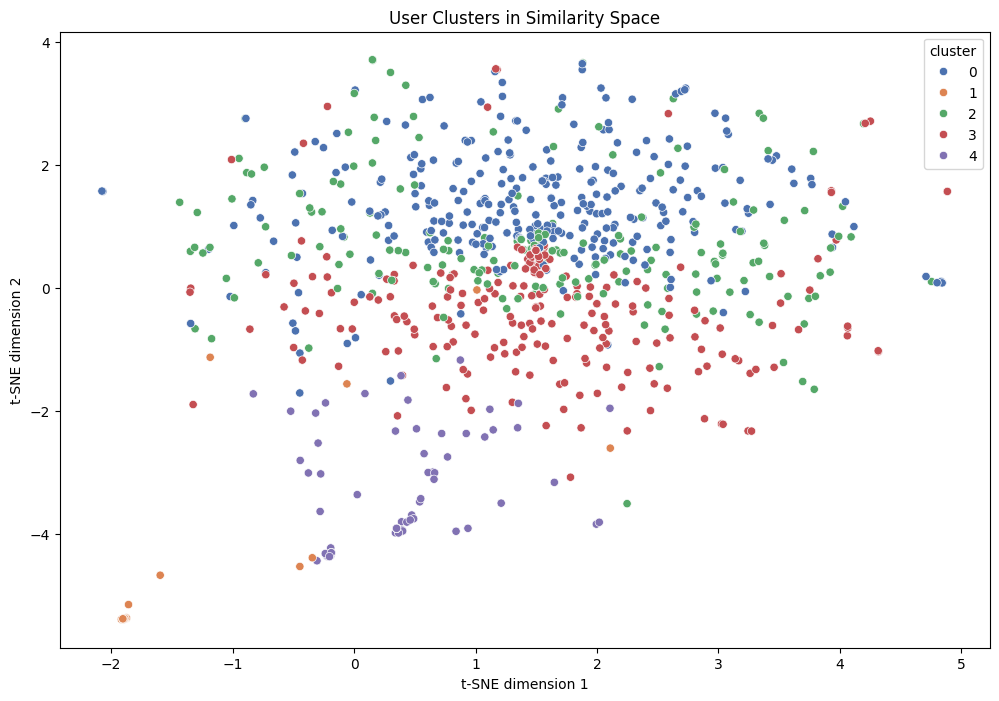

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.cluster import KMeans


# Ensure user_profile_matrix is 2D
if user_profile_matrix.ndim > 2:
    user_profile_matrix = np.array([profile.mean(axis=0).A[0] if sparse.issparse(profile)
                                    else profile.mean(axis=0)
                                    for profile in user_profile_matrix])

# Perform K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
cluster_labels = kmeans.fit_predict(user_profile_matrix)

# Perform t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
user_profile_2d = tsne.fit_transform(user_profile_matrix)

# Create a DataFrame with the t-SNE results and cluster labels
viz_df = pd.DataFrame({
    'x': user_profile_2d[:, 0],
    'y': user_profile_2d[:, 1],
    'cluster': cluster_labels,
    'user_id': list(user_profiles.keys())
})

# Visualize clusters in the t-SNE space
plt.figure(figsize=(12, 8))
sns.scatterplot(data=viz_df, x='x', y='y', hue='cluster', palette='deep', legend='full')
plt.title('User Clusters in Similarity Space')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')

# # Optionally, annotate points with user IDs
# for i, row in viz_df.iterrows():
#     plt.annotate(row['user_id'], (row['x'], row['y']), xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.7)

plt.show()


In [18]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Function to get BERT embeddings for a text
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze().numpy()

# Create user profiles using BERT embeddings
user_profiles_bert = {}
for user_id in sample_data['id'].unique():
    user_posts = sample_data[sample_data['id'] == user_id]['clean_data']
    user_vectors = [get_bert_embedding(post) for post in user_posts]
    user_profile = np.mean(user_vectors, axis=0)
    user_profiles_bert[user_id] = user_profile

# Calculate similarity using BERT embeddings
bert_similarity_matrix = cosine_similarity(list(user_profiles_bert.values()))

bert_similarity_matrix

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

array([[0.99999976, 0.60777074, 0.69388   , ..., 0.56217074, 0.67786235,
        0.6753738 ],
       [0.60777074, 1.0000001 , 0.8593757 , ..., 0.5628299 , 0.8498711 ,
        0.85984886],
       [0.69388   , 0.8593757 , 1.0000001 , ..., 0.5612921 , 0.9201696 ,
        0.89415205],
       ...,
       [0.56217074, 0.5628299 , 0.5612921 , ..., 0.9999999 , 0.5844955 ,
        0.622722  ],
       [0.67786235, 0.8498711 , 0.9201696 , ..., 0.5844955 , 1.0000002 ,
        0.8852082 ],
       [0.6753738 , 0.85984886, 0.89415205, ..., 0.622722  , 0.8852082 ,
        1.0000001 ]], dtype=float32)

In [19]:
def recommend_users_bert(user_id, n=5):
    user_index = list(user_profiles.keys()).index(user_id)
    similarities = bert_similarity_matrix[user_index]
    similar_indices = similarities.argsort()[-n-1:-1][::-1]
    similar_users = [list(user_profiles.keys())[i] for i in similar_indices]
    return [(user, similarities[i]) for i, user in zip(similar_indices, similar_users) if user != user_id]

# Example usage
example_user = sample_data['id'].iloc[0]
recommendations = recommend_users(example_user)
print(f"Top 5 recommended users for user {example_user}:")
for user, similarity in recommendations:
    print(f"User {user}: Similarity {similarity:.2f}")


Top 5 recommended users for user 3096879:
User 3208138: Similarity 0.76
User 477665: Similarity 0.72
User 4240657: Similarity 0.72
User 3935414: Similarity 0.71
User 1233897: Similarity 0.70


In [20]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

# Add sentiment score to the dataframe
sample_data['sentiment'] = sample_data['clean_data'].apply(get_sentiment)

# Calculate average sentiment per user
user_sentiment = sample_data.groupby('id')['sentiment'].mean()



In [21]:
user_sentiment

id
15365      0.124206
24336      0.200000
27603      0.312121
47519      0.195265
78196     -0.024306
             ...   
4281906   -0.176786
4282421   -0.100000
4289692   -0.166667
4296608   -0.025000
4312497    0.000000
Name: sentiment, Length: 832, dtype: float64